### **Imports and Setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ModuleNotFoundError: No module named 'matplotlib'

### **Model Training Class**

In [ ]:
class PostQualityPredictor:
    def __init__(self, model_path=None):
        self.model = None
        self.scaler = StandardScaler()
        self.feature_names = ['user_reputation', 'taker_mpxr_delta']
        self.model_path = model_path

    def load_data(self, file_path):
        """Load and prepare data"""
        try:
            df = pd.read_csv(file_path)
            X = df[self.feature_names]
            y = df['post_quality']
            return X, y
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            return None, None

    def preprocess_features(self, X):
        """Preprocess features"""
        return self.scaler.fit_transform(X)

    def train_model(self, X, y, hyperparameter_tuning=True):
        """Train the XGBoost model with optional hyperparameter tuning"""
        X_scaled = self.preprocess_features(X)
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=RANDOM_STATE
        )

        if hyperparameter_tuning:
            param_grid = {
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators': [100, 200, 300],
                'subsample': [0.8, 0.9],
                'colsample_bytree': [0.8, 0.9],
                'min_child_weight': [1, 3, 5]
            }

            grid_cv = GridSearchCV(
                estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE),
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=5,
                verbose=1,
                n_jobs=-1
            )

            grid_cv.fit(X_train, y_train)
            self.model = grid_cv.best_estimator_
            print(f"Best parameters: {grid_cv.best_params_}")
        else:
            self.model = xgb.XGBRegressor(
                objective='reg:squarederror',
                n_estimators=200,
                learning_rate=0.05,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=RANDOM_STATE
            )
            self.model.fit(X_train, y_train)

        return X_train, X_test, y_train, y_test

    def evaluate_model(self, X_test, y_test):
        """Evaluate model performance"""
        y_pred = self.model.predict(X_test)

        metrics = {
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'mae': mean_absolute_error(y_test, y_pred),
            'r2': r2_score(y_test, y_pred)
        }

        return metrics, y_pred

    def plot_results(self, X_test, y_test, y_pred):
        """Plot various model evaluation charts"""
        # Actual vs Predicted
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Actual Post Quality')
        plt.ylabel('Predicted Post Quality')
        plt.title('Actual vs Predicted')

        # Residuals
        plt.subplot(132)
        residuals = y_test - y_pred
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Post Quality')
        plt.ylabel('Residuals')
        plt.title('Residuals Plot')

        # Feature Importance
        plt.subplot(133)
        importances = self.model.feature_importances_
        sns.barplot(x=importances, y=self.feature_names)
        plt.xlabel('Feature Importance')
        plt.title('Feature Importance')

        plt.tight_layout()
        plt.show()

    def save_model(self, path):
        """Save model and scaler"""
        if self.model is not None:
            model_artifacts = {
                'model': self.model,
                'scaler': self.scaler,
                'feature_names': self.feature_names
            }
            joblib.dump(model_artifacts, path)
            print(f"Model saved to {path}")

    def load_model(self, path):
        """Load saved model and scaler"""
        try:
            model_artifacts = joblib.load(path)
            self.model = model_artifacts['model']
            self.scaler = model_artifacts['scaler']
            self.feature_names = model_artifacts['feature_names']
            print("Model loaded successfully")
        except Exception as e:
            print(f"Error loading model: {str(e)}")

    def predict(self, user_reputation, taker_mpxr_delta):
        """Make predictions for new data"""
        if self.model is None:
            print("Model not trained or loaded")
            return None

        input_features = pd.DataFrame({
            'user_reputation': [user_reputation],
            'taker_mpxr_delta': [taker_mpxr_delta]
        })

        scaled_features = self.scaler.transform(input_features)
        prediction = self.model.predict(scaled_features)[0]
        return prediction

## **Training and Evaluation**

Mounted at /content/drive
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}

Model Performance Metrics:
RMSE: 0.5761
MAE: 0.3781
R2: 0.8356


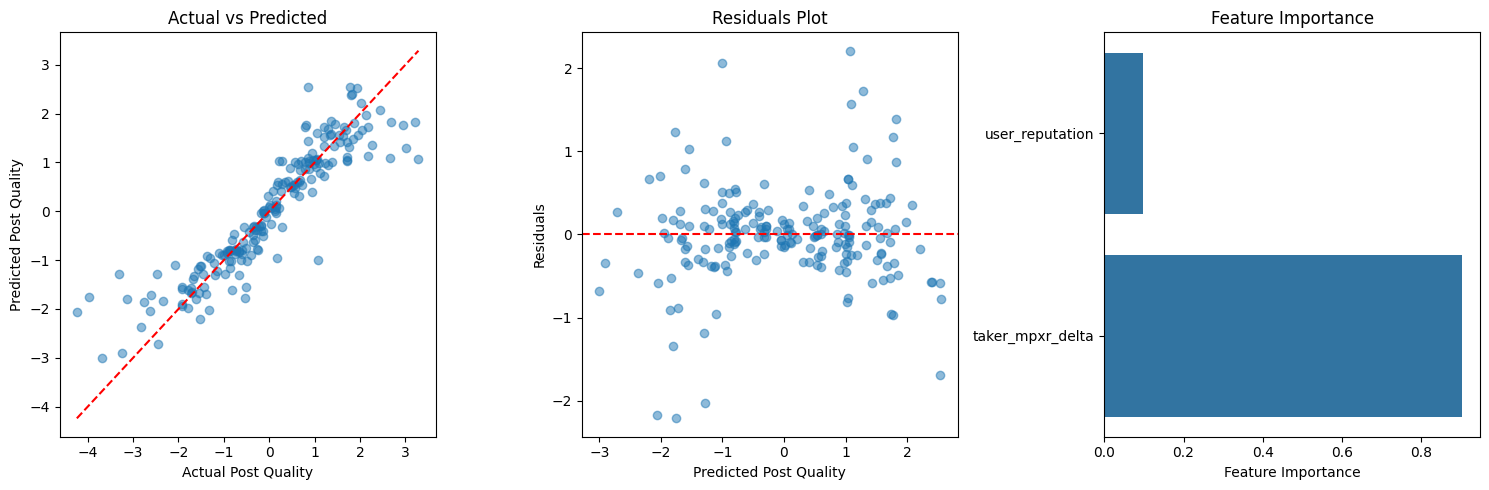

Model saved to /content/drive/MyDrive/post_quality_model.joblib


In [ ]:
# Mount Google Drive
# drive.mount('/content/drive')

# Initialize predictor
predictor = PostQualityPredictor()

# Load data
# file_path = '/content/drive/MyDrive/synthetic_data.csv'
file_path = 'predict\synthetic_data.csv'
X, y = predictor.load_data(file_path)

# Train model with hyperparameter tuning
X_train, X_test, y_train, y_test = predictor.train_model(X, y, hyperparameter_tuning=True)

# Evaluate model
metrics, y_pred = predictor.evaluate_model(X_test, y_test)
print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

# Plot results
predictor.plot_results(X_test, y_test, y_pred)

# Save model
# predictor.save_model('/content/drive/MyDrive/post_quality_model.joblib')
predictor.save_model('./post_quality_model.joblib')

### **Cross-Validation**

In [ ]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = []

for train_idx, val_idx in kf.split(X):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    # Train model on fold
    predictor_cv = PostQualityPredictor()
    predictor_cv.train_model(X_train_cv, y_train_cv, hyperparameter_tuning=False)

    # Evaluate on validation set
    metrics_cv, _ = predictor_cv.evaluate_model(X_val_cv, y_val_cv)
    cv_scores.append(metrics_cv['rmse'])

print(f"\nCross-validation RMSE scores: {cv_scores}")
print(f"Mean CV RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")


Cross-validation RMSE scores: [2.3874715324965528, 1.6038903280272323, 2.2639235693559683, 2.125495692152252, 2.3618988340277802]
Mean CV RMSE: 2.1485 (+/- 0.2874)


## **Making Predictions**

In [ ]:
# Load the saved model
new_predictor = PostQualityPredictor()
new_predictor.load_model('./post_quality_model.joblib')

# Make some example predictions
test_cases = [
    (100, -3.2),   # High reputation, positive interaction
    (100, -3.2),  # Medium reputation, negative interaction
    (350, 8.0),    # Very high reputation, strong positive interaction
    (250,5.5)
]

print("\nExample Predictions:")
for reputation, delta in test_cases:
    prediction = new_predictor.predict(reputation, delta)
    print(f"User Reputation: {reputation}, MPXR Delta: {delta:.1f}")
    print(f"Predicted Post Quality: {prediction:.2f}\n")

Model loaded successfully

Example Predictions:
User Reputation: 100, MPXR Delta: -3.2
Predicted Post Quality: -0.56

User Reputation: 100, MPXR Delta: -3.2
Predicted Post Quality: -0.56

User Reputation: 350, MPXR Delta: 8.0
Predicted Post Quality: 0.50

User Reputation: 250, MPXR Delta: 5.5
Predicted Post Quality: 1.21

